In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [47]:
class GD():
    def __init__(self, gamma, max_iter, x_start, func, sign=False, noise=False, delta=1, epsilon=0, sigma=0, kappa=2):
        self.gamma = gamma
        self.max_iter = max_iter
        self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX
        self.func = func
        self.logger = []
        self.sign = sign
        self.epsilon = epsilon
        self.delta = delta
        self.sigma = sigma
        self.kappa = kappa
        self.noise = noise

    def compute_grad(self):
        grad_func = jax.grad(self.func)  # Создаем функцию градиента
        return grad_func(self.x_current)  # Вычисляем градиент в текущей точке

    def stochastic_gradient(self, x):
        noise = np.random.normal(0,  np.abs(np.mean(self.x_current)), self.x_current.shape[0]) * 100
        return x + noise

    def step(self):
        grad = self.compute_grad()  # Получаем градиент
        if self.noise:
          grad = self.stochastic_gradient(grad)
        if self.sign:
          grad = np.sign(grad)
        self.x_current = self.x_current - self.gamma * grad  # Обновляем точку

    def run(self):
        self.logger.append(self.x_current.copy())  # Сохраняем начальную точку
        if self.epsilon == 0:
          for _ in range(self.max_iter):
            self.step()  # Выполняем шаг
            self.logger.append(self.x_current.copy())  # Сохраняем новое значение
        else: pass

    def get_logger(self):
        return self.logger

In [4]:
dataset = "mushrooms.txt"
#файл должен лежать в той же директории, что и notebook
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), (data[1] - 1.5)*2
n, d = X.shape

In [5]:
from sklearn.model_selection import train_test_split
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set: {X_train.shape[0]} obj., Test  set: {X_test.shape[0]} obj.")

Train set: 6499 obj., Test  set: 1625 obj.


In [6]:
X_train.shape

(6499, 112)

In [7]:
# Максимальная норма объектов
R = np.max(np.linalg.norm(X_train, axis=1, ord=2))
# R2 = np.linalg.norm(X_train @ X_train.T, ord=2)
print(R)
lambda_reg = 1.0
L1 = R + lambda_reg
L = R**2 + lambda_reg
print(f"L = {L}, L_1 = {L1}.")

4.58257569495584
L = 22.0, L_1 = 5.58257569495584.


In [8]:
delta = 0.99
gamma1 = 1 / (L1 * X_train.shape[1]**(3/2) * np.log(1 / delta))
gamma0 = 1 / (L * X_train.shape[1]**(3/2) * np.log(1 / delta))

In [9]:
print((f"gamma0 = {gamma0}, gamma1 = {gamma1}."))

gamma0 = 0.0038156603600980363, gamma1 = 0.01503688127292304.


In [10]:
from functools import partial
# Функция потерь (логистическая с регуляризацией)
def logistic_loss(w, X, y, lambda_reg):
    z = y * (X @ w)
    return jnp.mean(jnp.log(1 + jnp.exp(-z))) + (lambda_reg / 2) * jnp.sum(w**2)

# Запуск градиентного спуска
max_iter = 5000
w_0 =  np.random.normal(1, 3, X.shape[1])
func2 = partial(logistic_loss, X=X_train, y=y_train, lambda_reg=lambda_reg)
method = GD(gamma0, max_iter, w_0, func2, sign=False)
method.run()
logger = method.get_logger()

In [11]:
# Запуск градиентного спуска
gamma = 0.02 * L / L1
max_iter = 5000
method2 = GD(gamma1, max_iter, w_0, func2, sign=True)
method2.run()
logger2 = method2.get_logger()

In [12]:
w_opt1 = method.x_current
w_opt2 = method2.x_current
def predict(w, X):
    return jnp.sign(X @ w)
y_pred1 = predict(w_opt1, X_test)
y_pred2 = predict(w_opt2, X_test)
accuracy1 = np.mean(y_pred1 == y_test)
accuracy2 = np.mean(y_pred2 == y_test)
print(f"Точность модели 1: {accuracy1 * 100:.2f}%, Точность модели 2: {accuracy2 * 100:.2f}%")

Точность модели 1: 88.62%, Точность модели 2: 89.35%


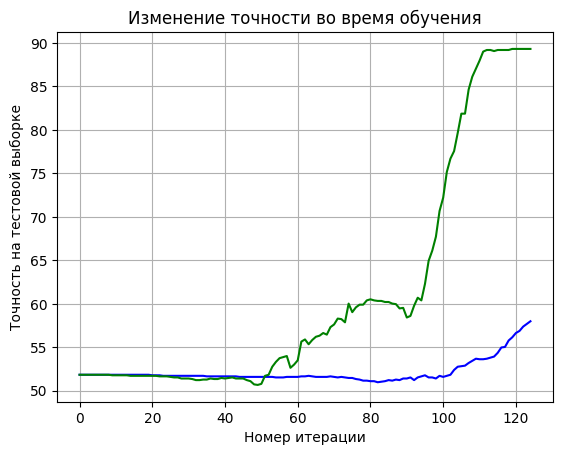

In [45]:
accuracies = np.array([np.mean(predict(w, X_test) == y_test) * 100 for w in logger[0::1]])
accuracies2 = np.array([np.mean(predict(w, X_test) == y_test) * 100 for w in logger2[0::1]])
# График изменения точности
plt.plot(accuracies[0:500:4], color='blue')
plt.plot(accuracies2[0:500:4], color='green')
plt.xlabel('Номер итерации')
plt.ylabel('Точность на тестовой выборке')
plt.title('Изменение точности во время обучения')
plt.grid(True)
plt.show()

In [48]:
# Запуск градиентного спуска
max_iter = 5000
func2 = partial(logistic_loss, X=X_train, y=y_train, lambda_reg=lambda_reg)
method3 = GD(gamma0, max_iter, w_0, func2, sign=False, noise=True)
method3.run()
logger3 = method.get_logger()

method4 = GD(gamma1, max_iter, w_0, func2, sign=True, noise=True)
method4.run()
logger4 = method.get_logger()

In [49]:
w_opt3 = method.x_current
w_opt4 = method2.x_current
y_pred3 = predict(w_opt3, X_test)
y_pred4 = predict(w_opt4, X_test)
accuracy3 = np.mean(y_pred3 == y_test)
accuracy4 = np.mean(y_pred4 == y_test)
print(f"Точность модели 1: {accuracy3 * 100:.2f}%, Точность модели 2: {accuracy4 * 100:.2f}%")

Точность модели 1: 88.62%, Точность модели 2: 89.35%


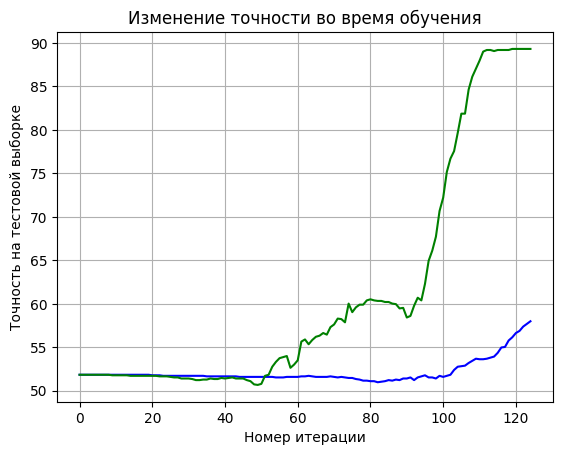

In [50]:
accuracies3 = np.array([np.mean(predict(w, X_test) == y_test) * 100 for w in logger3[0::1]])
accuracies4 = np.array([np.mean(predict(w, X_test) == y_test) * 100 for w in logger4[0::1]])
# График изменения точности
plt.plot(accuracies[0:500:4], color='blue')
plt.plot(accuracies2[0:500:4], color='green')
plt.xlabel('Номер итерации')
plt.ylabel('Точность на тестовой выборке')
plt.title('Изменение точности во время обучения')
plt.grid(True)
plt.show()